# Exercício em Python - Tema 8 - Mudanças Climáticas

O objetivo deste exercício é comparar as séries observadas com os sinais projetados por modelos CMIP5/CMIP6.

## 1.Importação de Bibliotecas

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, io
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import seaborn as sns

## 2. Importação da Base de Dados

In [7]:
# Bacias escolhidas representando diferentes biomas/regionais hidrográficas
bacias = ['15', '411', '195', '443', '607']
nomes_bacias = {
    '15': 'Amazônia',
    '411': 'Cerrado',
    '195': 'Caatinga',
    '443': 'Mata Atlântica',
    '607': 'Pampa'
}

variaveis = {
    'tmin': 'Temperatura Mínima (C)',
    'tmax': 'Temperatura Máxima (C)',
    'p': 'Precipitação (mm)',
    'pet_pm': 'Evapotranspiração Potencial (mm)'
}

# Dicionário para armazenar os DataFrames por bacia
dfs = {}

In [8]:
# Etapa 1: Importação e agregação anual sem função
i = 0
for b in bacias:
    url = f"https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_climate_daily_series/ens/CABra_{b}_climate_ENS.txt"
    r = requests.get(url).content
    df = pd.read_csv(io.StringIO(r.decode('utf-8', errors='ignore')), skiprows=13, delimiter='\t')
    df.columns = ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']
    #Exclui linha 0 pois não faz parte dos dados
    df = df.drop([0], axis=0)
    #Passando todos os dados para categoria numérica
    df = df.apply(pd.to_numeric)
    #Definir coluna de data
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df['year'] = df['date'].dt.year
    df_ano = df.groupby('year')[['tmin', 'tmax', 'p', 'pet_pm']].mean().reset_index()
    dfs[b] = df_ano
    i += 1

##3. Gráfico de comparação das variações climáticas (1980 - 2010)

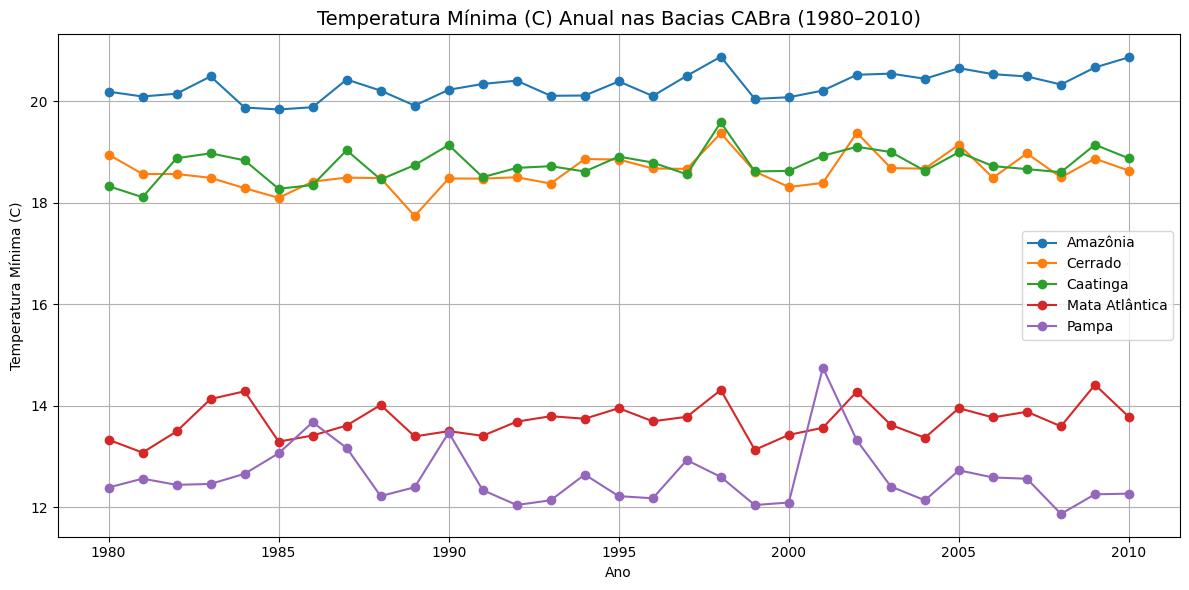

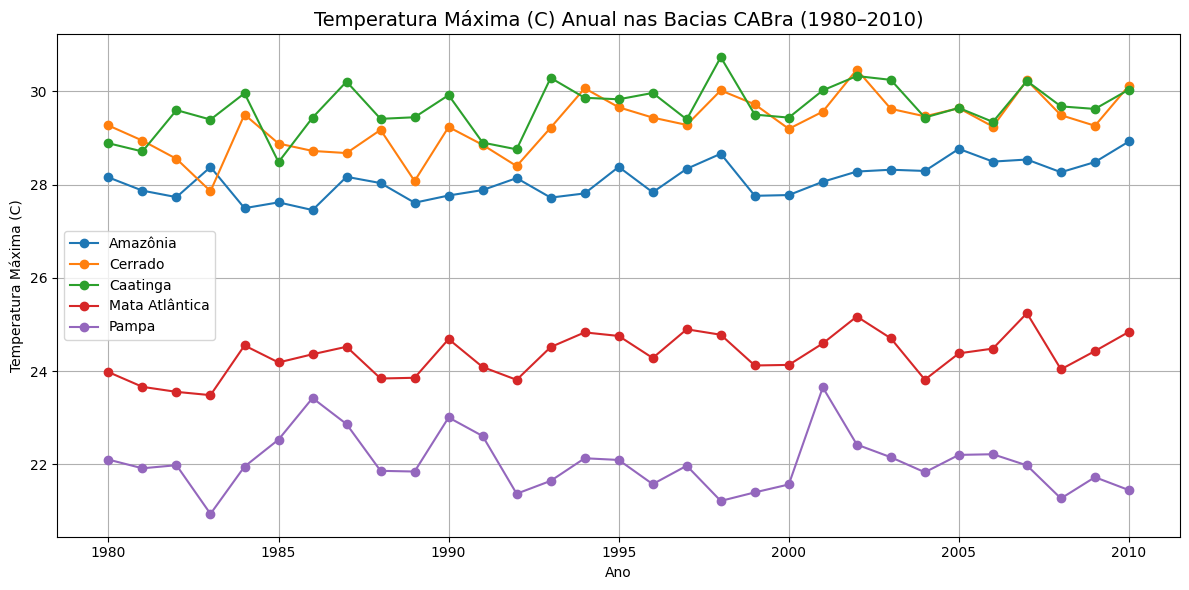

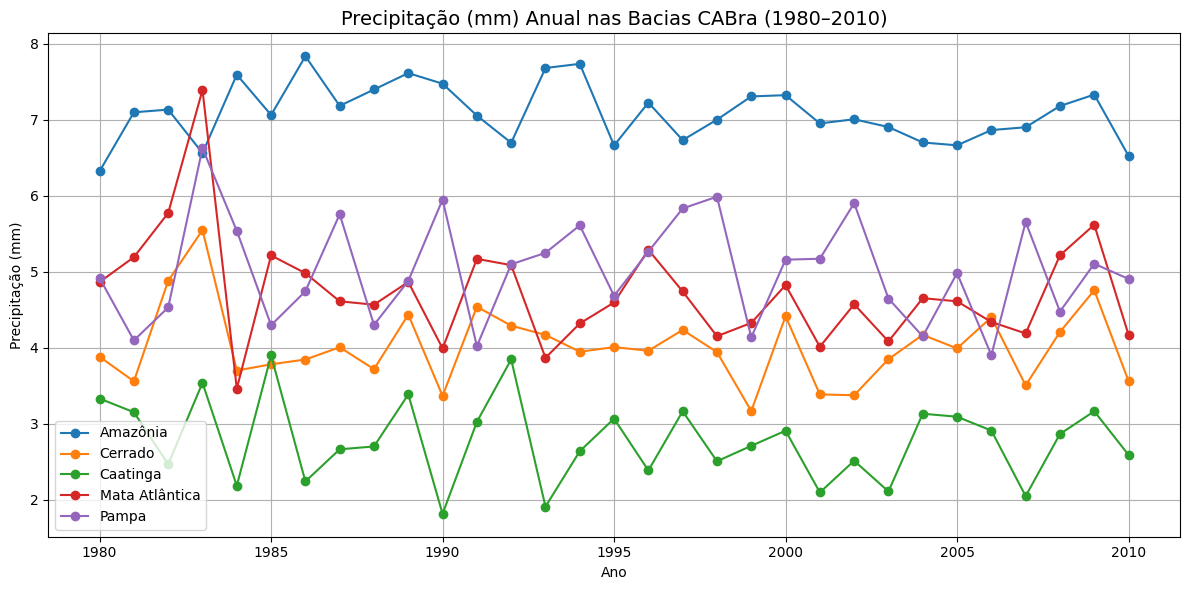

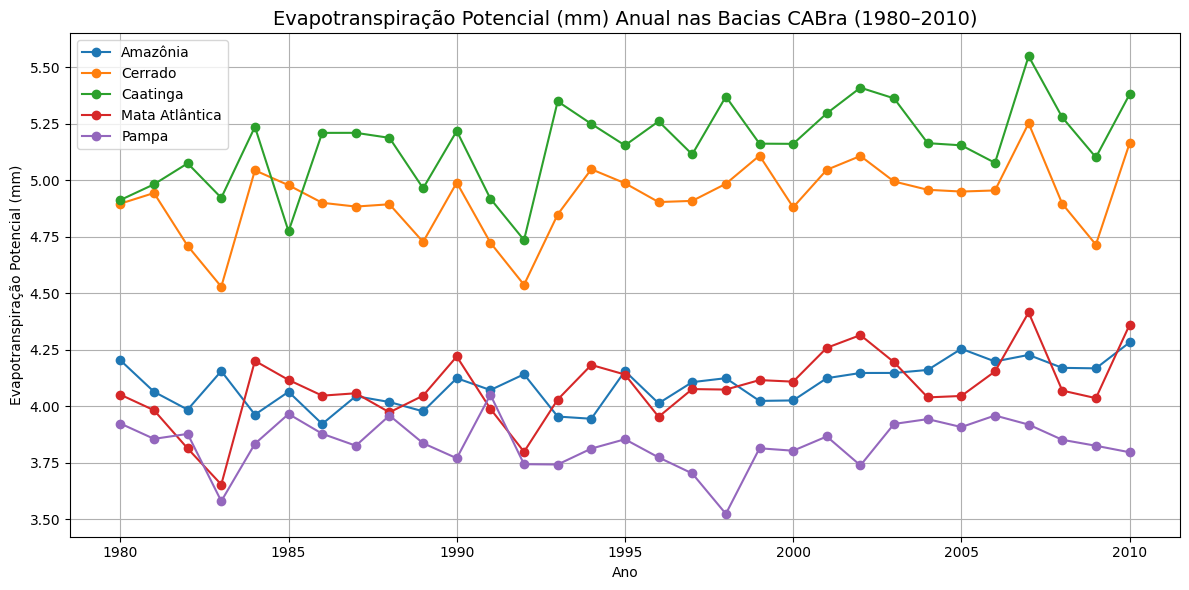

In [9]:
# Etapa 2: Gráficos de comparação
for var, nome_var in variaveis.items():
    plt.figure(figsize=(12, 6))
    for b in bacias:
        df = dfs[b]
        # Ensure there are non-null values before plotting
        if not df.empty:
            plt.plot(df['year'], df[var], label=f"{nomes_bacias[b]}", marker='o')
    plt.title(f"{nome_var} Anual nas Bacias CABra (1980–2010)", fontsize=14)
    plt.xlabel('Ano')
    plt.ylabel(nome_var)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

##4. Gráfico de comparação das variações climáticas com linhas de tendência (1980 - 2010)

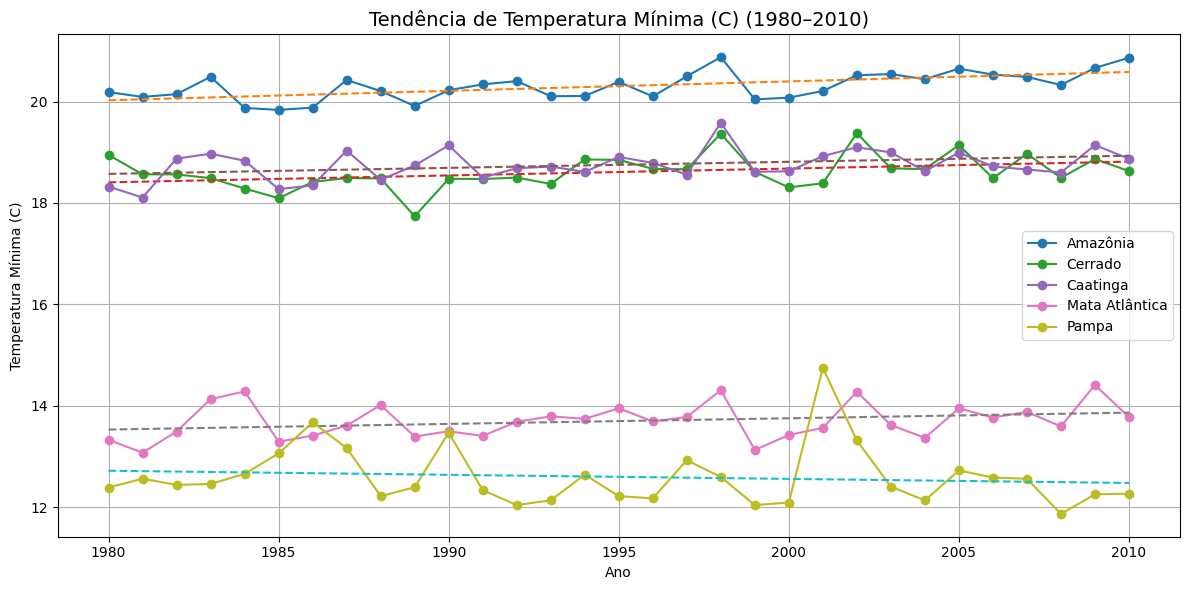

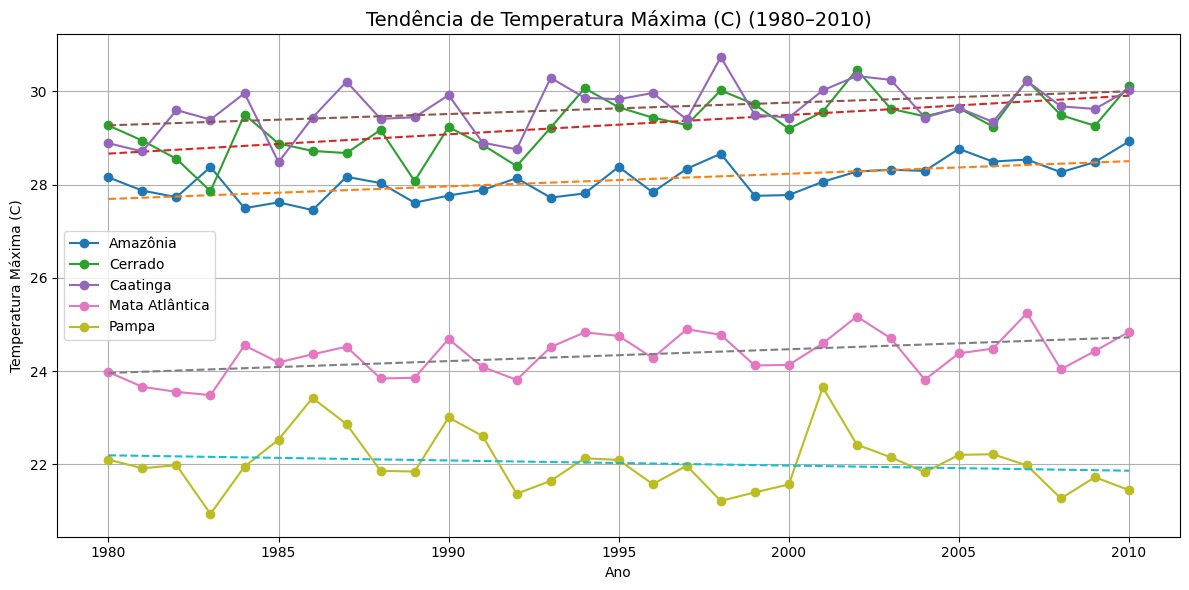

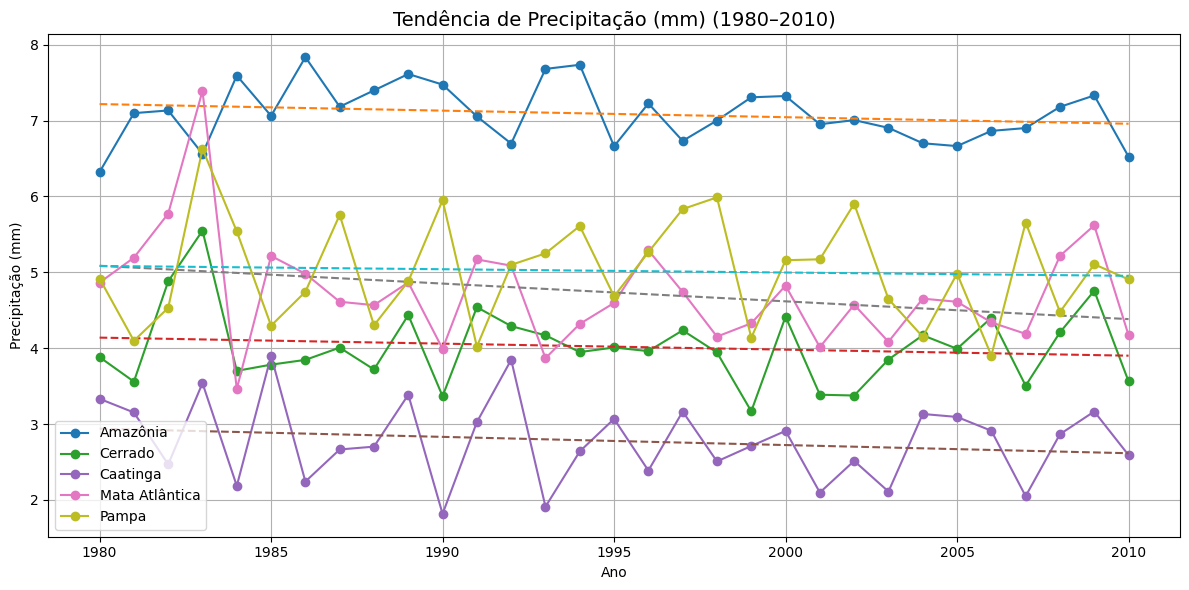

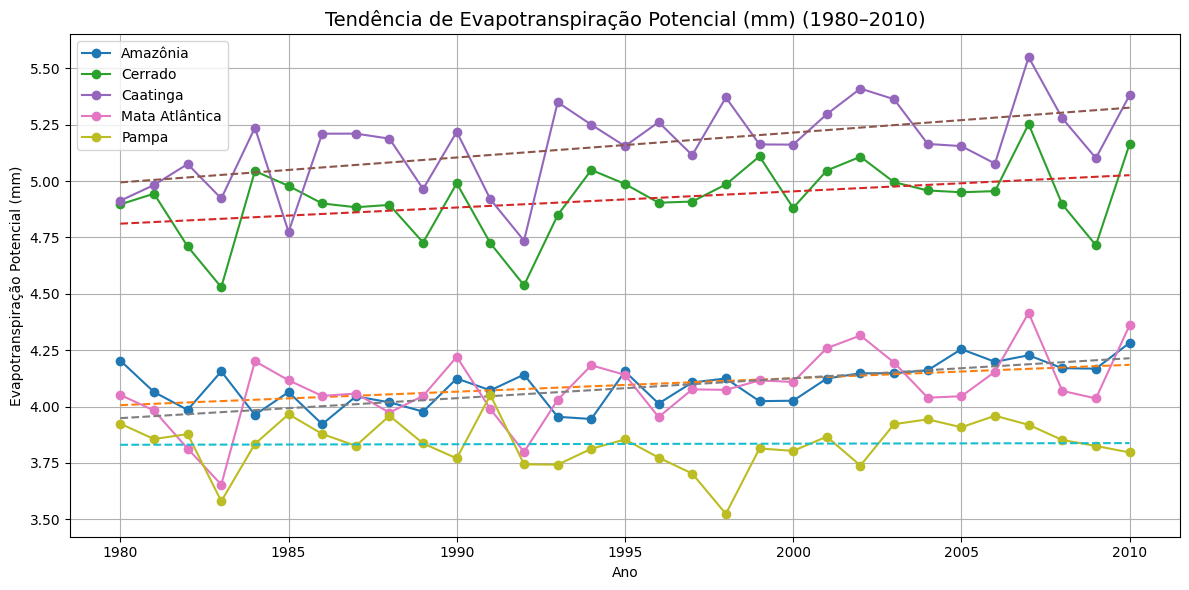

In [10]:
# Etapa 3 (opcional): Adicionar tendência linear
for var, nome_var in variaveis.items():
    plt.figure(figsize=(12, 6))
    for b in bacias:
        df = dfs[b]
        # Ensure there are enough non-null values for linear regression
        if not df.empty and len(df) > 1:
            X = df['year'].values.reshape(-1, 1)
            y = df[var].values
            # Filter out NaN values for linear regression
            not_nan_mask = ~np.isnan(y)
            X_filtered = X[not_nan_mask]
            y_filtered = y[not_nan_mask]

            if len(X_filtered) > 1: # Ensure there are at least two points to fit a line
                model = LinearRegression().fit(X_filtered, y_filtered)
                y_pred = model.predict(X)
                plt.plot(df['year'], y, label=f"{nomes_bacias[b]}", marker='o', linestyle='-')
                plt.plot(df['year'], y_pred, linestyle='--')
            else:
                plt.plot(df['year'], y, label=f"{nomes_bacias[b]}", marker='o', linestyle='-') # Plot without trend if not enough data

    plt.title(f"Tendência de {nome_var} (1980–2010)", fontsize=14)
    plt.xlabel('Ano')
    plt.ylabel(nome_var)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

##5. Significância das variações climáticas (1980 - 2010)

In [11]:
#Cálculo da significância estatística das variações

print("Significância estatística das tendências (1980–2010):\n")

for var, nome_var in variaveis.items():
    print(f"Variável: {nome_var}")
    for b in bacias:
        df = dfs[b]
        x = df['year'].values
        y = df[var].values
        result = linregress(x, y)
        slope = result.slope
        p_value = result.pvalue
        r2 = result.rvalue**2
        sig = "significativa" if p_value < 0.05 else "não significativa"
        print(f"  - {nomes_bacias[b]}: inclinação = {slope:.3f}, p = {p_value:.3f}, R² = {r2:.2f} → {sig}")
    print()

Significância estatística das tendências (1980–2010):

Variável: Temperatura Mínima (C)
  - Amazônia: inclinação = 0.019, p = 0.000, R² = 0.38 → significativa
  - Cerrado: inclinação = 0.014, p = 0.041, R² = 0.14 → significativa
  - Caatinga: inclinação = 0.012, p = 0.047, R² = 0.13 → significativa
  - Mata Atlântica: inclinação = 0.011, p = 0.113, R² = 0.08 → não significativa
  - Pampa: inclinação = -0.008, p = 0.509, R² = 0.02 → não significativa

Variável: Temperatura Máxima (C)
  - Amazônia: inclinação = 0.027, p = 0.000, R² = 0.41 → significativa
  - Cerrado: inclinação = 0.041, p = 0.000, R² = 0.39 → significativa
  - Caatinga: inclinação = 0.024, p = 0.019, R² = 0.18 → significativa
  - Mata Atlântica: inclinação = 0.025, p = 0.004, R² = 0.25 → significativa
  - Pampa: inclinação = -0.011, p = 0.384, R² = 0.03 → não significativa

Variável: Precipitação (mm)
  - Amazônia: inclinação = -0.009, p = 0.270, R² = 0.04 → não significativa
  - Cerrado: inclinação = -0.008, p = 0.441, 

##6. Correlação entre tendências de variáveis climáticas (1980 - 2010)


Correlação entre variáveis climáticas agregadas (1980–2010):

Matriz de correlação - Amazônia:
        tmin  tmax     p  pet_pm
tmin    1.00  0.92 -0.61    0.76
tmax    0.92  1.00 -0.74    0.86
p      -0.61 -0.74  1.00   -0.80
pet_pm  0.76  0.86 -0.80    1.00


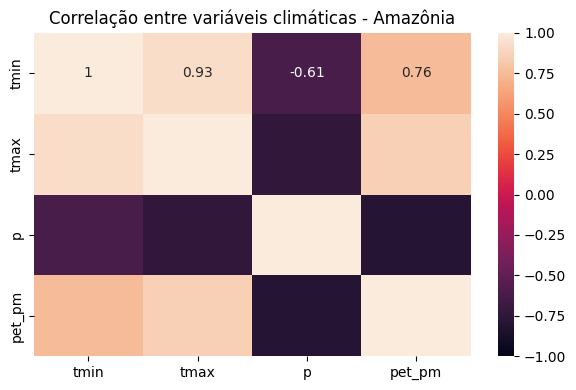


Matriz de correlação - Cerrado:
        tmin  tmax     p  pet_pm
tmin    1.00  0.64 -0.14    0.34
tmax    0.64  1.00 -0.54    0.84
p      -0.14 -0.54  1.00   -0.80
pet_pm  0.34  0.84 -0.80    1.00


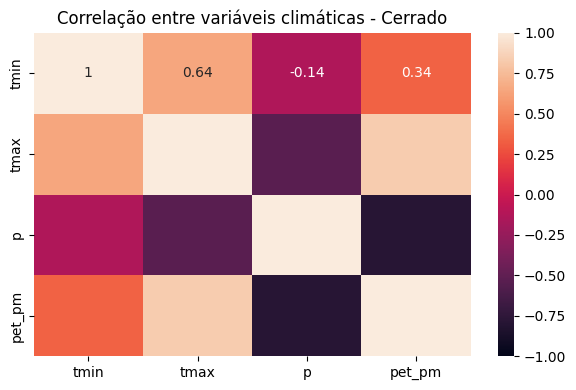


Matriz de correlação - Caatinga:
        tmin  tmax     p  pet_pm
tmin    1.00  0.67 -0.32    0.37
tmax    0.67  1.00 -0.75    0.89
p      -0.32 -0.75  1.00   -0.81
pet_pm  0.37  0.89 -0.81    1.00


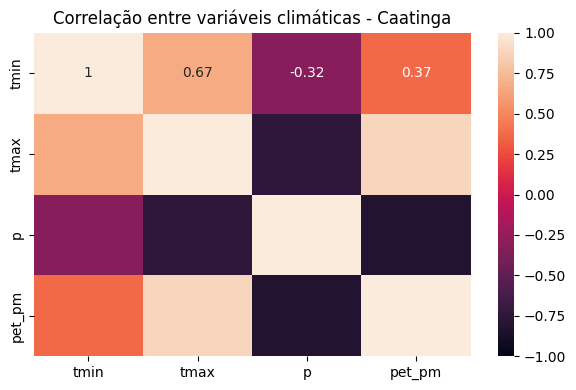


Matriz de correlação - Mata Atlântica:
        tmin  tmax     p  pet_pm
tmin    1.00  0.48 -0.27    0.12
tmax    0.48  1.00 -0.66    0.79
p      -0.27 -0.66  1.00   -0.68
pet_pm  0.12  0.79 -0.68    1.00


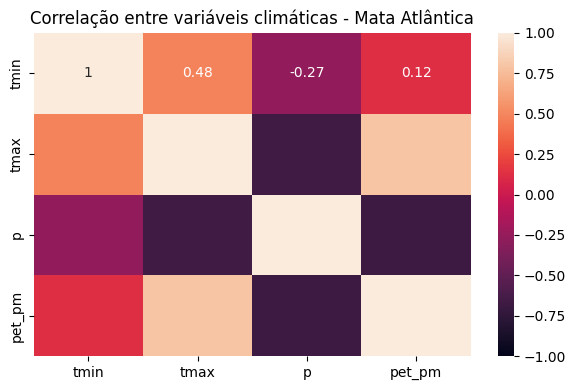


Matriz de correlação - Pampa:
        tmin  tmax     p  pet_pm
tmin    1.00  0.72  0.39    0.02
tmax    0.72  1.00 -0.07    0.48
p       0.39 -0.07  1.00   -0.74
pet_pm  0.02  0.48 -0.74    1.00


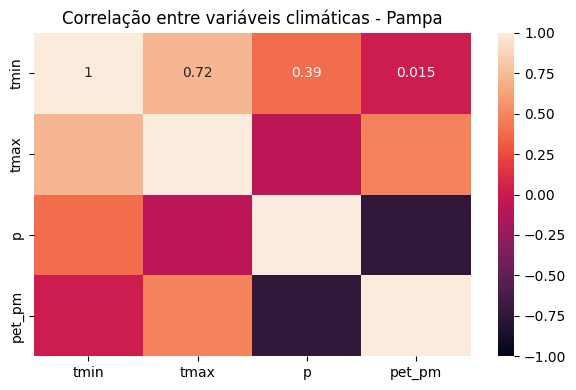

In [12]:
# Etapa 4: Correlação entre tendências de variáveis climáticas
print("\nCorrelação entre variáveis climáticas agregadas (1980–2010):")

for b in bacias:
    df = dfs[b].copy()
    df_corr = df[['tmin', 'tmax', 'p', 'pet_pm']].corr(method='spearman')
    print(f"\nMatriz de correlação - {nomes_bacias[b]}:")
    print(df_corr.round(2))
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1)
    plt.title(f"Correlação entre variáveis climáticas - {nomes_bacias[b]}")
    plt.tight_layout()
    plt.show()